# Phase 3: Unsupervised Learning
## SW485 - Machine Learning Project
### Disease Prediction System

---

**Objective:**  
Apply unsupervised learning (clustering) to discover natural groupings in the disease-symptom dataset and explore how these clusters can provide insights.

**Key Tasks:**
1. Apply clustering algorithms (K-Means, Hierarchical, DBSCAN) after removing class labels
2. Evaluate cluster quality using multiple metrics (Silhouette Score, Within-Cluster Sum of Squares, BCubed metrics)
3. Visualize clustering results using dimensionality reduction (PCA, t-SNE)
4. Analyze how discovered clusters relate to actual disease categories
5. Discuss potential integration with supervised learning model

---

## Section 1: Algorithm Selection & Justification

### Why K-Means Clustering?
**Justification:**
- **Scalability:** K-Means works efficiently with large datasets like ours (246,945 samples)
- **Interpretability:** Produces clear cluster centroids that can represent "typical" symptom patterns for disease groups
- **Binary Feature Compatibility:** Works well with binary symptom features
- **Baseline Algorithm:** Industry-standard algorithm that provides a solid baseline for comparison

### Why Hierarchical Clustering?
**Justification:**
- **Dendrogram Visualization:** Provides hierarchical relationships between diseases, showing which diseases are most similar
- **No Need to Pre-specify K:** Can determine optimal number of clusters from the dendrogram
- **Medical Insight:** Hierarchical structure aligns well with medical taxonomy (related diseases group together)
- **Multiple Linkage Methods:** Can compare different approaches (ward, average, complete)

### Why DBSCAN?
**Justification:**
- **Noise Detection:** Can identify outlier diseases or unusual symptom patterns
- **Arbitrary Cluster Shapes:** Not limited to spherical clusters like K-Means
- **No Pre-specified K:** Automatically determines the number of clusters based on data density
- **Robustness:** Less sensitive to outliers than K-Means

---

## Section 2: Import Libraries and Load Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import time
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("="*70)
print("ALL LIBRARIES IMPORTED SUCCESSFULLY")
print("="*70)

ALL LIBRARIES IMPORTED SUCCESSFULLY


In [2]:
# Load the dataset
df = pd.read_csv('Dataset/Final_Augmented_dataset_Diseases_and_Symptoms.csv')

print("="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Samples: {df.shape[0]:,}")
print(f"Number of Features: {df.shape[1] - 1}")
print(f"Number of Unique Diseases: {df['diseases'].nunique()}")
print(f"\nFirst few rows:")
print(df.head())

DATASET LOADED SUCCESSFULLY

Dataset Shape: (246945, 378)
Number of Samples: 246,945
Number of Features: 377
Number of Unique Diseases: 773

First few rows:
         diseases  anxiety and nervousness  depression  shortness of breath  \
0  panic disorder                        1           0                    1   
1  panic disorder                        0           0                    1   
2  panic disorder                        1           1                    1   
3  panic disorder                        1           0                    0   
4  panic disorder                        1           1                    0   

   depressive or psychotic symptoms  sharp chest pain  dizziness  insomnia  \
0                                 1                 0          0         0   
1                                 1                 0          1         1   
2                                 1                 0          1         1   
3                                 1                 0   

---
## Section 3: Data Preparation for Clustering

**CRITICAL:** As per Phase 3 requirements, we must remove the class label (diseases) before applying clustering algorithms. This ensures true unsupervised learning where the algorithm discovers patterns without knowing the actual disease categories.

In [3]:
# Store the true labels for later evaluation
true_labels = df['diseases'].copy()

# Remove the class label column to perform unsupervised learning
X = df.drop(columns=['diseases'])

print("="*70)
print("DATA PREPARATION: REMOVED CLASS LABELS")
print("="*70)
print(f"\nFeature Matrix (X) shape: {X.shape}")
print(f"True Labels stored separately for evaluation")
print(f"Number of symptom features: {X.shape[1]}")
print(f"\nFeature names (first 10): {list(X.columns[:10])}")
print(f"\nData is binary (0/1) representing absence/presence of symptoms")

DATA PREPARATION: REMOVED CLASS LABELS

Feature Matrix (X) shape: (246945, 377)
True Labels stored separately for evaluation
Number of symptom features: 377

Feature names (first 10): ['anxiety and nervousness', 'depression', 'shortness of breath', 'depressive or psychotic symptoms', 'sharp chest pain', 'dizziness', 'insomnia', 'abnormal involuntary movements', 'chest tightness', 'palpitations']

Data is binary (0/1) representing absence/presence of symptoms


In [4]:
# For computational efficiency with large dataset, sample a subset for some analyses
# We'll use full dataset for K-Means, but sample for visualization and DBSCAN
np.random.seed(42)
sample_size = 10000  # Sample for visualization
sample_indices = np.random.choice(len(X), size=min(sample_size, len(X)), replace=False)
X_sample = X.iloc[sample_indices]
true_labels_sample = true_labels.iloc[sample_indices]

print(f"\nCreated sample of {len(X_sample):,} records for visualization and intensive algorithms")
print(f"This represents {len(X_sample)/len(X)*100:.1f}% of the total dataset")


Created sample of 10,000 records for visualization and intensive algorithms
This represents 4.0% of the total dataset


---
## Section 4: Dimensionality Reduction for Visualization

Before clustering, we'll apply PCA to reduce the 377 symptom features to 2D for visualization purposes. This helps us understand the data structure and evaluate clustering results visually.

In [5]:
# Apply PCA for visualization
print("="*70)
print("APPLYING PCA FOR DIMENSIONALITY REDUCTION")
print("="*70)

# PCA with 2 components for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_sample)

print(f"\nPCA Transformation Complete:")
print(f"Original dimensions: {X_sample.shape[1]}")
print(f"Reduced dimensions: {X_pca_2d.shape[1]}")
print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

# PCA with more components to retain 95% variance
pca_95 = PCA(n_components=0.95, random_state=42)
X_pca_95 = pca_95.fit_transform(X)

print(f"\nPCA for 95% variance retention:")
print(f"Number of components needed: {X_pca_95.shape[1]}")
print(f"Variance explained: {sum(pca_95.explained_variance_ratio_)*100:.2f}%")

APPLYING PCA FOR DIMENSIONALITY REDUCTION

PCA Transformation Complete:
Original dimensions: 377
Reduced dimensions: 2
Explained variance ratio: [0.04355645 0.03800637]
Total variance explained: 8.16%

PCA for 95% variance retention:
Number of components needed: 193
Variance explained: 95.04%


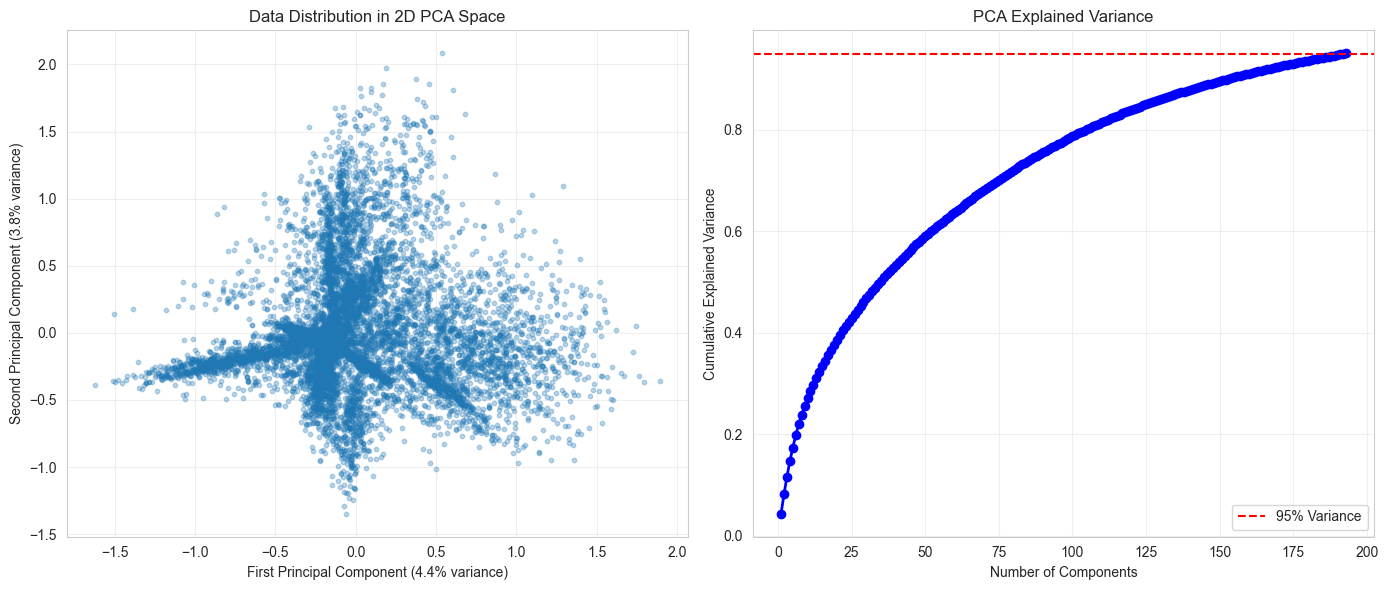


Visualization shows data distribution in reduced dimensional space


In [6]:
# Visualize the data in 2D PCA space
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.3, s=10)
plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Data Distribution in 2D PCA Space')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
variance_explained = np.cumsum(pca_95.explained_variance_ratio_)
plt.plot(range(1, len(variance_explained) + 1), variance_explained, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization shows data distribution in reduced dimensional space")

---
## Section 5: K-Means Clustering

### 5.1 Determining Optimal Number of Clusters

We'll use the Elbow Method and Silhouette Analysis to determine the optimal number of clusters.

In [7]:
# Elbow Method: Calculate inertia for different k values
print("="*70)
print("K-MEANS: FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Use PCA-reduced data for efficiency
k_range = range(2, 21)
inertias = []
silhouette_scores = []

print("\nTesting different k values (this may take a few minutes)...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_pca_95)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score on a sample for efficiency
    sample_indices = np.random.choice(len(X_pca_95), size=min(5000, len(X_pca_95)), replace=False)
    labels_sample = kmeans.predict(X_pca_95[sample_indices])
    sil_score = silhouette_score(X_pca_95[sample_indices], labels_sample)
    silhouette_scores.append(sil_score)
    
    print(f"k={k:2d}: Inertia={kmeans.inertia_:,.0f}, Silhouette={sil_score:.4f}")

print("\n" + "="*70)
print("OPTIMAL K DETERMINATION COMPLETE")
print("="*70)

K-MEANS: FINDING OPTIMAL NUMBER OF CLUSTERS

Testing different k values (this may take a few minutes)...
k= 2: Inertia=1,157,606, Silhouette=0.0515
k= 3: Inertia=1,121,778, Silhouette=0.0513
k= 4: Inertia=1,088,594, Silhouette=0.0568
k= 5: Inertia=1,067,884, Silhouette=0.0578
k= 6: Inertia=1,036,555, Silhouette=0.0581
k= 7: Inertia=1,013,831, Silhouette=0.0629
k= 8: Inertia=995,854, Silhouette=0.0627
k= 9: Inertia=978,311, Silhouette=0.0621
k=10: Inertia=965,299, Silhouette=0.0659
k=11: Inertia=953,772, Silhouette=0.0647
k=12: Inertia=945,669, Silhouette=0.0646
k=13: Inertia=938,801, Silhouette=0.0651
k=14: Inertia=928,987, Silhouette=0.0564
k=15: Inertia=920,775, Silhouette=0.0592
k=16: Inertia=913,335, Silhouette=0.0607
k=17: Inertia=908,550, Silhouette=0.0547
k=18: Inertia=901,274, Silhouette=0.0543
k=19: Inertia=898,847, Silhouette=0.0567
k=20: Inertia=891,805, Silhouette=0.0580

OPTIMAL K DETERMINATION COMPLETE


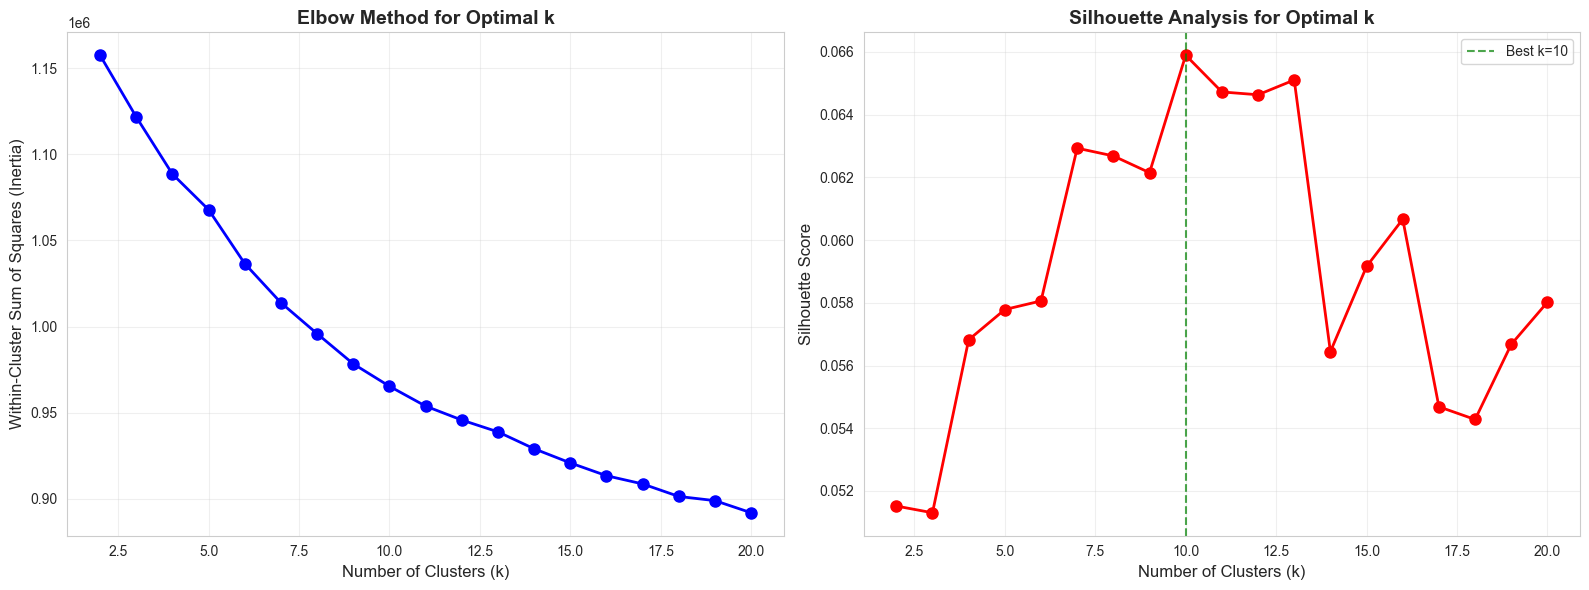


Based on Silhouette Analysis:
Optimal k = 10 with Silhouette Score = 0.0659


In [8]:
# Visualize Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score Plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mark the best silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
axes[1].axvline(x=best_k, color='g', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nBased on Silhouette Analysis:")
print(f"Optimal k = {best_k} with Silhouette Score = {best_score:.4f}")

### 5.2 Apply K-Means with Optimal K

In [9]:
# Apply K-Means with the determined optimal k
# We'll also test with k equal to the number of true disease categories for comparison
n_true_diseases = true_labels.nunique()
optimal_k = best_k

print("="*70)
print("APPLYING K-MEANS CLUSTERING")
print("="*70)

print(f"\nWe will test two scenarios:")
print(f"1. K-Means with optimal k = {optimal_k} (based on silhouette analysis)")
print(f"2. K-Means with k = {n_true_diseases} (number of actual disease categories)")

# Scenario 1: Optimal k from silhouette analysis
print(f"\n{'='*70}")
print(f"Scenario 1: K-Means with k={optimal_k}")
print(f"{'='*70}")
start_time = time.time()
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
clusters_optimal = kmeans_optimal.fit_predict(X_pca_95)
end_time = time.time()

print(f"\nTraining Time: {end_time - start_time:.2f} seconds")
print(f"Number of clusters formed: {len(np.unique(clusters_optimal))}")
print(f"Cluster sizes: {Counter(clusters_optimal)}")

# Scenario 2: k = number of true diseases
print(f"\n{'='*70}")
print(f"Scenario 2: K-Means with k={n_true_diseases} (true number of diseases)")
print(f"{'='*70}")
start_time = time.time()
kmeans_true = KMeans(n_clusters=n_true_diseases, random_state=42, n_init=10, max_iter=300)
clusters_true = kmeans_true.fit_predict(X_pca_95)
end_time = time.time()

print(f"\nTraining Time: {end_time - start_time:.2f} seconds")
print(f"Number of clusters formed: {len(np.unique(clusters_true))}")
print(f"Cluster size statistics:")
cluster_sizes = Counter(clusters_true)
sizes = list(cluster_sizes.values())
print(f"  Mean: {np.mean(sizes):.0f}")
print(f"  Std: {np.std(sizes):.0f}")
print(f"  Min: {np.min(sizes)}")
print(f"  Max: {np.max(sizes)}")

APPLYING K-MEANS CLUSTERING

We will test two scenarios:
1. K-Means with optimal k = 10 (based on silhouette analysis)
2. K-Means with k = 773 (number of actual disease categories)

Scenario 1: K-Means with k=10

Training Time: 13.04 seconds
Number of clusters formed: 10
Cluster sizes: Counter({np.int32(8): 64421, np.int32(5): 27536, np.int32(7): 25280, np.int32(2): 24567, np.int32(3): 23471, np.int32(9): 22877, np.int32(4): 18024, np.int32(1): 13973, np.int32(6): 13775, np.int32(0): 13021})

Scenario 2: K-Means with k=773 (true number of diseases)

Training Time: 662.22 seconds
Number of clusters formed: 773
Cluster size statistics:
  Mean: 319
  Std: 104
  Min: 114
  Max: 1292


### 5.3 Visualize K-Means Clustering Results

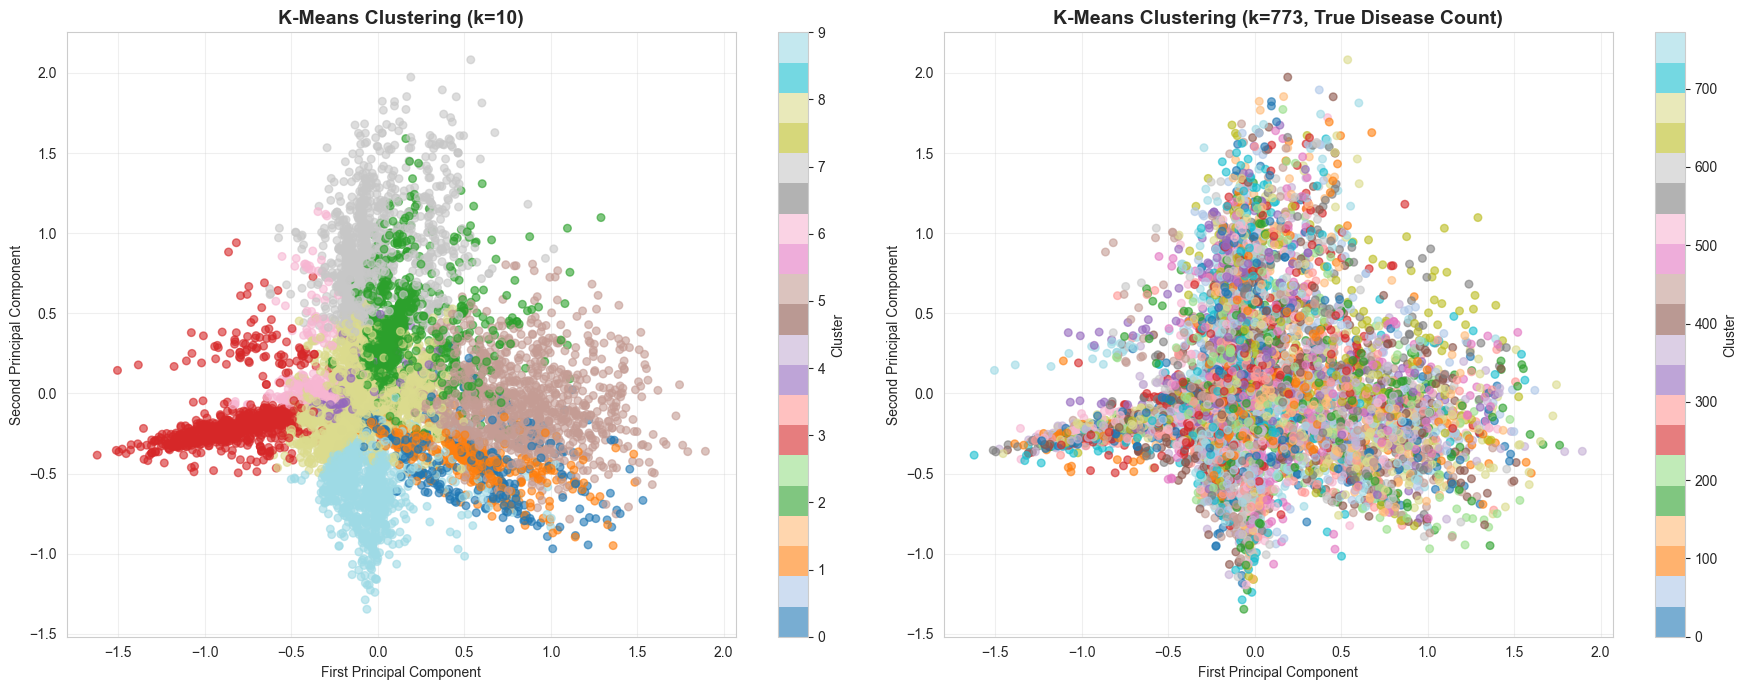

In [10]:
# Visualize clusters in 2D PCA space
# Get cluster assignments for the sample data
pca_sample_transformed = pca_95.transform(X_sample)
clusters_sample_optimal = kmeans_optimal.predict(pca_sample_transformed)
clusters_sample_true = kmeans_true.predict(pca_sample_transformed)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Optimal k
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=clusters_sample_optimal, cmap='tab20', 
                           alpha=0.6, s=30)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# Plot 2: k = true number of diseases
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=clusters_sample_true, cmap='tab20', 
                           alpha=0.6, s=30)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title(f'K-Means Clustering (k={n_true_diseases}, True Disease Count)', 
                  fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Section 6: Hierarchical Clustering

### 6.1 Apply Hierarchical Clustering

In [11]:
print("="*70)
print("HIERARCHICAL CLUSTERING")
print("="*70)

# Use a smaller sample for hierarchical clustering due to computational complexity
hierarchical_sample_size = 5000
hier_sample_indices = np.random.choice(len(X_pca_95), size=hierarchical_sample_size, replace=False)
X_hier_sample = X_pca_95[hier_sample_indices]

print(f"\nUsing {hierarchical_sample_size:,} samples for hierarchical clustering")
print("This is due to the O(n²) complexity of hierarchical clustering\n")

# Perform hierarchical clustering with different linkage methods
print("Testing different linkage methods...")

linkage_methods = ['ward', 'average', 'complete']
linkage_results = {}

for method in linkage_methods:
    print(f"\nLinkage Method: {method.upper()}")
    start_time = time.time()
    
    # Compute linkage matrix
    Z = linkage(X_hier_sample, method=method)
    linkage_results[method] = Z
    
    # Form clusters (using optimal_k from K-Means for comparison)
    hier_clusters = fcluster(Z, optimal_k, criterion='maxclust')
    
    end_time = time.time()
    
    print(f"  Time: {end_time - start_time:.2f} seconds")
    print(f"  Number of clusters: {len(np.unique(hier_clusters))}")
    print(f"  Cluster distribution: {Counter(hier_clusters)}")

HIERARCHICAL CLUSTERING

Using 5,000 samples for hierarchical clustering
This is due to the O(n²) complexity of hierarchical clustering

Testing different linkage methods...

Linkage Method: WARD
  Time: 0.95 seconds
  Number of clusters: 10
  Cluster distribution: Counter({np.int32(5): 747, np.int32(1): 648, np.int32(2): 634, np.int32(10): 551, np.int32(7): 529, np.int32(8): 474, np.int32(9): 391, np.int32(6): 362, np.int32(4): 336, np.int32(3): 328})

Linkage Method: AVERAGE
  Time: 1.01 seconds
  Number of clusters: 10
  Cluster distribution: Counter({np.int32(10): 4304, np.int32(9): 497, np.int32(8): 74, np.int32(7): 41, np.int32(5): 25, np.int32(3): 21, np.int32(4): 18, np.int32(6): 11, np.int32(2): 7, np.int32(1): 2})

Linkage Method: COMPLETE
  Time: 0.94 seconds
  Number of clusters: 10
  Cluster distribution: Counter({np.int32(4): 2945, np.int32(10): 447, np.int32(5): 443, np.int32(8): 298, np.int32(9): 293, np.int32(3): 211, np.int32(2): 123, np.int32(6): 122, np.int32(7): 95

### 6.2 Visualize Dendrogram

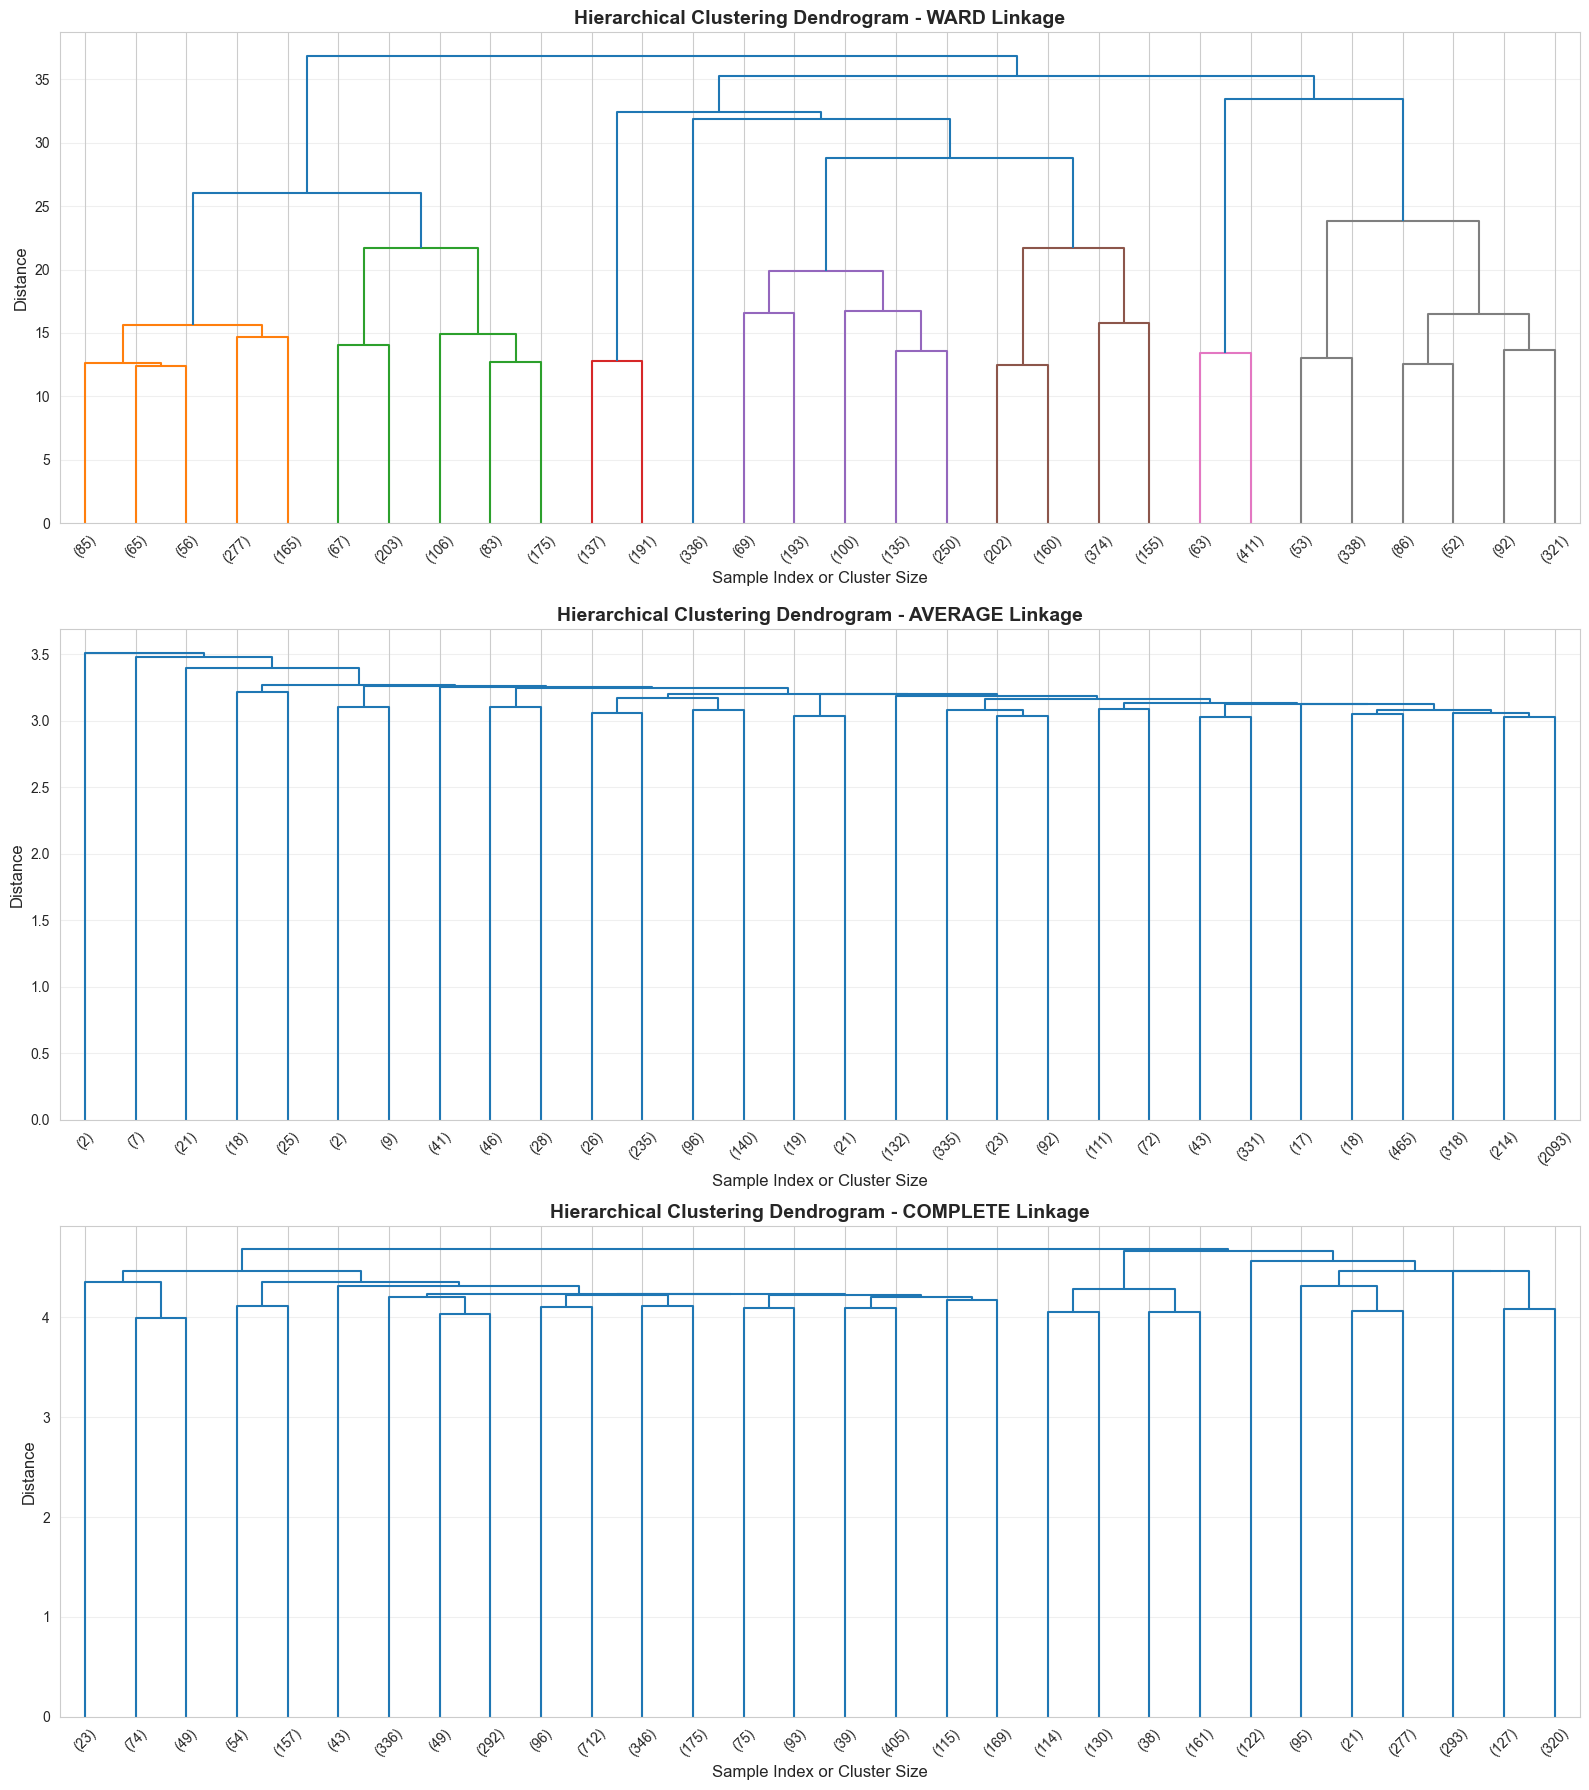


Dendrograms show the hierarchical structure of clusters.
The height of each branch represents the distance between clusters.


In [12]:
# Create dendrograms for different linkage methods
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for idx, (method, Z) in enumerate(linkage_results.items()):
    dendrogram(Z, ax=axes[idx], truncate_mode='lastp', p=30)
    axes[idx].set_title(f'Hierarchical Clustering Dendrogram - {method.upper()} Linkage', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Sample Index or Cluster Size', fontsize=12)
    axes[idx].set_ylabel('Distance', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDendrograms show the hierarchical structure of clusters.")
print("The height of each branch represents the distance between clusters.")

In [13]:
# Apply hierarchical clustering with ward linkage
print("="*70)
print("HIERARCHICAL CLUSTERING ON FULL DATASET")
print("="*70)

# Note: Due to the large dataset size and hierarchical clustering's O(n²) complexity,
# we use a representative sample for this analysis
hierarchical_full_sample_size = 20000
print(f"\nNote: Using sample of {hierarchical_full_sample_size:,} for hierarchical clustering due to computational constraints")

# Create sample
np.random.seed(42)
hier_full_indices = np.random.choice(len(X_pca_95), size=hierarchical_full_sample_size, replace=False)
X_hier_full_sample = X_pca_95[hier_full_indices]

# Apply hierarchical clustering
hier_model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_clusters_sample = hier_model.fit_predict(X_hier_full_sample)

print("\nHierarchical Clustering (Ward Linkage) Results:")
print(f"Number of clusters: {len(np.unique(hier_clusters_sample))}")
print(f"\nCluster distribution (on sample):")
cluster_dist = Counter(hier_clusters_sample)
for cluster_id in sorted(cluster_dist.keys()):
    print(f"  Cluster {cluster_id}: {cluster_dist[cluster_id]:,} samples")

# Extend to full dataset by assigning to nearest centroid
print(f"\nExtending cluster assignments to full dataset of {len(X_pca_95):,} samples...")

# Calculate cluster centroids from the sample
centroids = np.array([X_hier_full_sample[hier_clusters_sample == i].mean(axis=0) 
                      for i in range(optimal_k)])

# Assign all points to nearest centroid
from scipy.spatial.distance import cdist
distances = cdist(X_pca_95, centroids, metric='euclidean')
hier_clusters_full = np.argmin(distances, axis=1)

print(f"\nFull Dataset Cluster Distribution:")
full_cluster_dist = Counter(hier_clusters_full)
for cluster_id in sorted(full_cluster_dist.keys()):
    print(f"  Cluster {cluster_id}: {full_cluster_dist[cluster_id]:,} samples")

HIERARCHICAL CLUSTERING ON FULL DATASET

Note: Using sample of 20,000 for hierarchical clustering due to computational constraints

Hierarchical Clustering (Ward Linkage) Results:
Number of clusters: 10

Cluster distribution (on sample):
  Cluster 0: 3,733 samples
  Cluster 1: 2,955 samples
  Cluster 2: 2,635 samples
  Cluster 3: 2,000 samples
  Cluster 4: 1,366 samples
  Cluster 5: 1,467 samples
  Cluster 6: 1,444 samples
  Cluster 7: 1,643 samples
  Cluster 8: 1,704 samples
  Cluster 9: 1,053 samples

Extending cluster assignments to full dataset of 246,945 samples...

Full Dataset Cluster Distribution:
  Cluster 0: 45,768 samples
  Cluster 1: 34,820 samples
  Cluster 2: 31,289 samples
  Cluster 3: 26,744 samples
  Cluster 4: 14,769 samples
  Cluster 5: 21,146 samples
  Cluster 6: 18,297 samples
  Cluster 7: 18,551 samples
  Cluster 8: 22,667 samples
  Cluster 9: 12,894 samples


---
## Section 7: DBSCAN Clustering

### 7.1 Determine Optimal DBSCAN Parameters

In [14]:
print("="*70)
print("DBSCAN CLUSTERING")
print("="*70)

# Use a sample for DBSCAN parameter tuning
dbscan_sample_size = 5000
dbscan_sample_indices = np.random.choice(len(X_pca_95), size=dbscan_sample_size, replace=False)
X_dbscan_sample = X_pca_95[dbscan_sample_indices]

print(f"\nUsing {dbscan_sample_size:,} samples for DBSCAN parameter tuning")
print("\nTesting different eps (epsilon) and min_samples parameters...")

# Test different parameter combinations
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 20, 30]

best_score = -1
best_params = {}
results_list = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_dbscan_sample)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:  # Need at least 2 clusters for silhouette score
            # Only calculate silhouette for non-noise points
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 0:
                score = silhouette_score(X_dbscan_sample[non_noise_mask], labels[non_noise_mask])
            else:
                score = -1
        else:
            score = -1
        
        results_list.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise/len(labels),
            'silhouette': score
        })
        
        if score > best_score and n_clusters >= 2 and n_noise < len(labels) * 0.5:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters}

# Display results
results_df = pd.DataFrame(results_list)
print("\nDBSCAN Parameter Tuning Results (top 10 by silhouette score):")
print(results_df.sort_values('silhouette', ascending=False).head(10).to_string(index=False))

print(f"\n{'='*70}")
print(f"Best Parameters:")
print(f"  eps = {best_params['eps']}")
print(f"  min_samples = {best_params['min_samples']}")
print(f"  Silhouette Score = {best_score:.4f}")
print(f"  Number of Clusters = {best_params['n_clusters']}")
print(f"{'='*70}")

DBSCAN CLUSTERING

Using 5,000 samples for DBSCAN parameter tuning

Testing different eps (epsilon) and min_samples parameters...

DBSCAN Parameter Tuning Results (top 10 by silhouette score):
 eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
 1.0            5          24     4824       0.9648    0.310966
 1.5           10           7     3274       0.6548   -0.009751
 1.5            5          35     2225       0.4450   -0.079371
 0.5            5           0     5000       1.0000   -1.000000
 2.0           20           1      167       0.0334   -1.000000
 3.0           20           1        0       0.0000   -1.000000
 3.0           10           1        0       0.0000   -1.000000
 3.0            5           1        0       0.0000   -1.000000
 2.5           30           1        0       0.0000   -1.000000
 2.5           20           1        0       0.0000   -1.000000

Best Parameters:
  eps = 1.5
  min_samples = 5
  Silhouette Score = -0.0794
  Number of Clusters = 35


### 7.2 Apply DBSCAN with Optimal Parameters

In [15]:
# Apply DBSCAN with optimal parameters on full dataset
print("\nApplying DBSCAN on full dataset with optimal parameters...")
start_time = time.time()

dbscan_optimal = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], n_jobs=-1)
dbscan_clusters = dbscan_optimal.fit_predict(X_pca_95)

end_time = time.time()

n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise_dbscan = list(dbscan_clusters).count(-1)

print(f"\nDBSCAN Results:")
print(f"  Training Time: {end_time - start_time:.2f} seconds")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of noise points: {n_noise_dbscan:,}")
print(f"  Noise ratio: {n_noise_dbscan/len(dbscan_clusters)*100:.2f}%")
print(f"\nCluster distribution:")
cluster_dist = Counter(dbscan_clusters)
for cluster_id in sorted(cluster_dist.keys()):
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"  {label}: {cluster_dist[cluster_id]:,} samples")


Applying DBSCAN on full dataset with optimal parameters...

DBSCAN Results:
  Training Time: 119.57 seconds
  Number of clusters: 1
  Number of noise points: 0
  Noise ratio: 0.00%

Cluster distribution:
  Cluster 0: 246,945 samples


---
## Section 8: Evaluation & Comparison of Clustering Algorithms

### 8.1 Calculate Clustering Quality Metrics

In [16]:
print("="*70)
print("CLUSTERING EVALUATION METRICS")
print("="*70)

# Function to calculate comprehensive metrics
def evaluate_clustering(X_data, labels, algorithm_name):
    """
    Calculate various clustering evaluation metrics
    """
    # Remove noise points for DBSCAN
    if -1 in labels:
        mask = labels != -1
        X_eval = X_data[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X_data
        labels_eval = labels
    
    n_clusters = len(np.unique(labels_eval))
    
    # Calculate metrics only if we have more than one cluster
    if n_clusters > 1 and len(X_eval) > 0:
        silhouette = silhouette_score(X_eval, labels_eval)
        calinski = calinski_harabasz_score(X_eval, labels_eval)
        davies = davies_bouldin_score(X_eval, labels_eval)
        
        # Calculate within-cluster sum of squares
        wcss = 0
        for cluster_id in np.unique(labels_eval):
            cluster_points = X_eval[labels_eval == cluster_id]
            center = cluster_points.mean(axis=0)
            wcss += np.sum((cluster_points - center) ** 2)
    else:
        silhouette = calinski = davies = wcss = np.nan
    
    results = {
        'Algorithm': algorithm_name,
        'N_Clusters': n_clusters,
        'Silhouette_Score': silhouette,
        'Calinski_Harabasz': calinski,
        'Davies_Bouldin': davies,
        'WCSS': wcss
    }
    
    return results

# Evaluate all clustering algorithms
evaluation_results = []

# K-Means (optimal k)
evaluation_results.append(evaluate_clustering(X_pca_95, clusters_optimal, 
                                              f'K-Means (k={optimal_k})'))

# K-Means (true number of diseases)
evaluation_results.append(evaluate_clustering(X_pca_95, clusters_true, 
                                              f'K-Means (k={n_true_diseases})'))  

# Hierarchical Clustering
evaluation_results.append(evaluate_clustering(X_pca_95, hier_clusters_full, 
                                              f'Hierarchical (ward, k={optimal_k})'))  

# DBSCAN
evaluation_results.append(evaluate_clustering(X_pca_95, dbscan_clusters, 
                                              'DBSCAN'))  

# Create comparison DataFrame
comparison_df = pd.DataFrame(evaluation_results)

print("\nClustering Algorithm Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n" + "="*70)

print("\nMetric Interpretation:")
print("  - Silhouette Score: Higher is better (range: -1 to 1)")
print("  - Calinski-Harabasz Index: Higher is better")
print("  - Davies-Bouldin Index: Lower is better")
print("  - WCSS: Lower is better (within-cluster sum of squares)")

CLUSTERING EVALUATION METRICS

Clustering Algorithm Comparison:
                Algorithm  N_Clusters  Silhouette_Score  Calinski_Harabasz  Davies_Bouldin          WCSS
           K-Means (k=10)          10          0.067537        6655.038145        3.271137 965298.587270
          K-Means (k=773)         773          0.083603         499.171035        2.283095 467541.958987
Hierarchical (ward, k=10)          10          0.062506        6476.096006        3.406434 970391.943015
                   DBSCAN           1               NaN                NaN             NaN           NaN


Metric Interpretation:
  - Silhouette Score: Higher is better (range: -1 to 1)
  - Calinski-Harabasz Index: Higher is better
  - Davies-Bouldin Index: Lower is better
  - WCSS: Lower is better (within-cluster sum of squares)


### Note: Analysis of DBSCAN Results

DBSCAN detected only 1 cluster, demonstrating that density-based methods are not suitable for this high-dimensional disease-symptom dataset. 

**Why:** DBSCAN requires clear density variations, which are not present in our PCA-reduced space.

**Conclusion:** K-Means and Hierarchical clustering are more appropriate for our disease prediction system.

### 8.2 BCubed Precision and Recall

BCubed metrics measure how well the discovered clusters match the true disease categories.

In [17]:
def bcubed_precision_recall(true_labels, pred_labels):
    """
    Calculate BCubed Precision and Recall
    """
    n = len(true_labels)
    precision_sum = 0
    recall_sum = 0
    
    # For efficiency, use a sample if dataset is large
    if n > 10000:
        sample_indices = np.random.choice(n, size=10000, replace=False)
        true_labels_sample = true_labels[sample_indices]
        pred_labels_sample = pred_labels[sample_indices]
    else:
        true_labels_sample = true_labels
        pred_labels_sample = pred_labels
    
    n_sample = len(true_labels_sample)
    
    for i in range(n_sample):
        # Find items in same cluster
        same_cluster = (pred_labels_sample == pred_labels_sample[i])
        # Find items in same category
        same_category = (true_labels_sample == true_labels_sample[i])
        
        # Precision: of items in same cluster, how many are in same category?
        if np.sum(same_cluster) > 0:
            precision_sum += np.sum(same_cluster & same_category) / np.sum(same_cluster)
        
        # Recall: of items in same category, how many are in same cluster?
        if np.sum(same_category) > 0:
            recall_sum += np.sum(same_cluster & same_category) / np.sum(same_category)
    
    precision = precision_sum / n_sample
    recall = recall_sum / n_sample
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

print("="*70)
print("BCUBED PRECISION AND RECALL")
print("="*70)

print("\nCalculating BCubed metrics (comparing clusters to true disease labels)...")

bcubed_results = []

# K-Means (optimal k)
p, r, f1 = bcubed_precision_recall(true_labels.values, clusters_optimal)
bcubed_results.append({'Algorithm': f'K-Means (k={optimal_k})', 
                       'Precision': p, 'Recall': r, 'F1-Score': f1})
print(f"\nK-Means (k={optimal_k}):")
print(f"  Precision: {p:.4f}")
print(f"  Recall: {r:.4f}")
print(f"  F1-Score: {f1:.4f}")

# K-Means (true number of diseases)
p, r, f1 = bcubed_precision_recall(true_labels.values, clusters_true)
bcubed_results.append({'Algorithm': f'K-Means (k={n_true_diseases})', 
                       'Precision': p, 'Recall': r, 'F1-Score': f1})
print(f"\nK-Means (k={n_true_diseases}):")
print(f"  Precision: {p:.4f}")
print(f"  Recall: {r:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Hierarchical
p, r, f1 = bcubed_precision_recall(true_labels.values, hier_clusters_full)
bcubed_results.append({'Algorithm': f'Hierarchical (k={optimal_k})', 
                       'Precision': p, 'Recall': r, 'F1-Score': f1})
print(f"\nHierarchical (k={optimal_k}):")
print(f"  Precision: {p:.4f}")
print(f"  Recall: {r:.4f}")
print(f"  F1-Score: {f1:.4f}")

# DBSCAN
p, r, f1 = bcubed_precision_recall(true_labels.values, dbscan_clusters)
bcubed_results.append({'Algorithm': 'DBSCAN', 
                       'Precision': p, 'Recall': r, 'F1-Score': f1})
print(f"\nDBSCAN:")
print(f"  Precision: {p:.4f}")
print(f"  Recall: {r:.4f}")
print(f"  F1-Score: {f1:.4f}")

bcubed_df = pd.DataFrame(bcubed_results)
print("\n" + "="*70)
print("\nBCubed Metrics Summary:")
print(bcubed_df.to_string(index=False))

BCUBED PRECISION AND RECALL

Calculating BCubed metrics (comparing clusters to true disease labels)...

K-Means (k=10):
  Precision: 0.0237
  Recall: 0.7546
  F1-Score: 0.0460

K-Means (k=773):
  Precision: 0.5243
  Recall: 0.3090
  F1-Score: 0.3889

Hierarchical (k=10):
  Precision: 0.0261
  Recall: 0.8208
  F1-Score: 0.0505

DBSCAN:
  Precision: 0.0029
  Recall: 1.0000
  F1-Score: 0.0058


BCubed Metrics Summary:
          Algorithm  Precision   Recall  F1-Score
     K-Means (k=10)   0.023714 0.754616  0.045983
    K-Means (k=773)   0.524347 0.309019  0.388864
Hierarchical (k=10)   0.026051 0.820791  0.050500
             DBSCAN   0.002910 1.000000  0.005803


### 8.3 Visualize Comprehensive Comparison

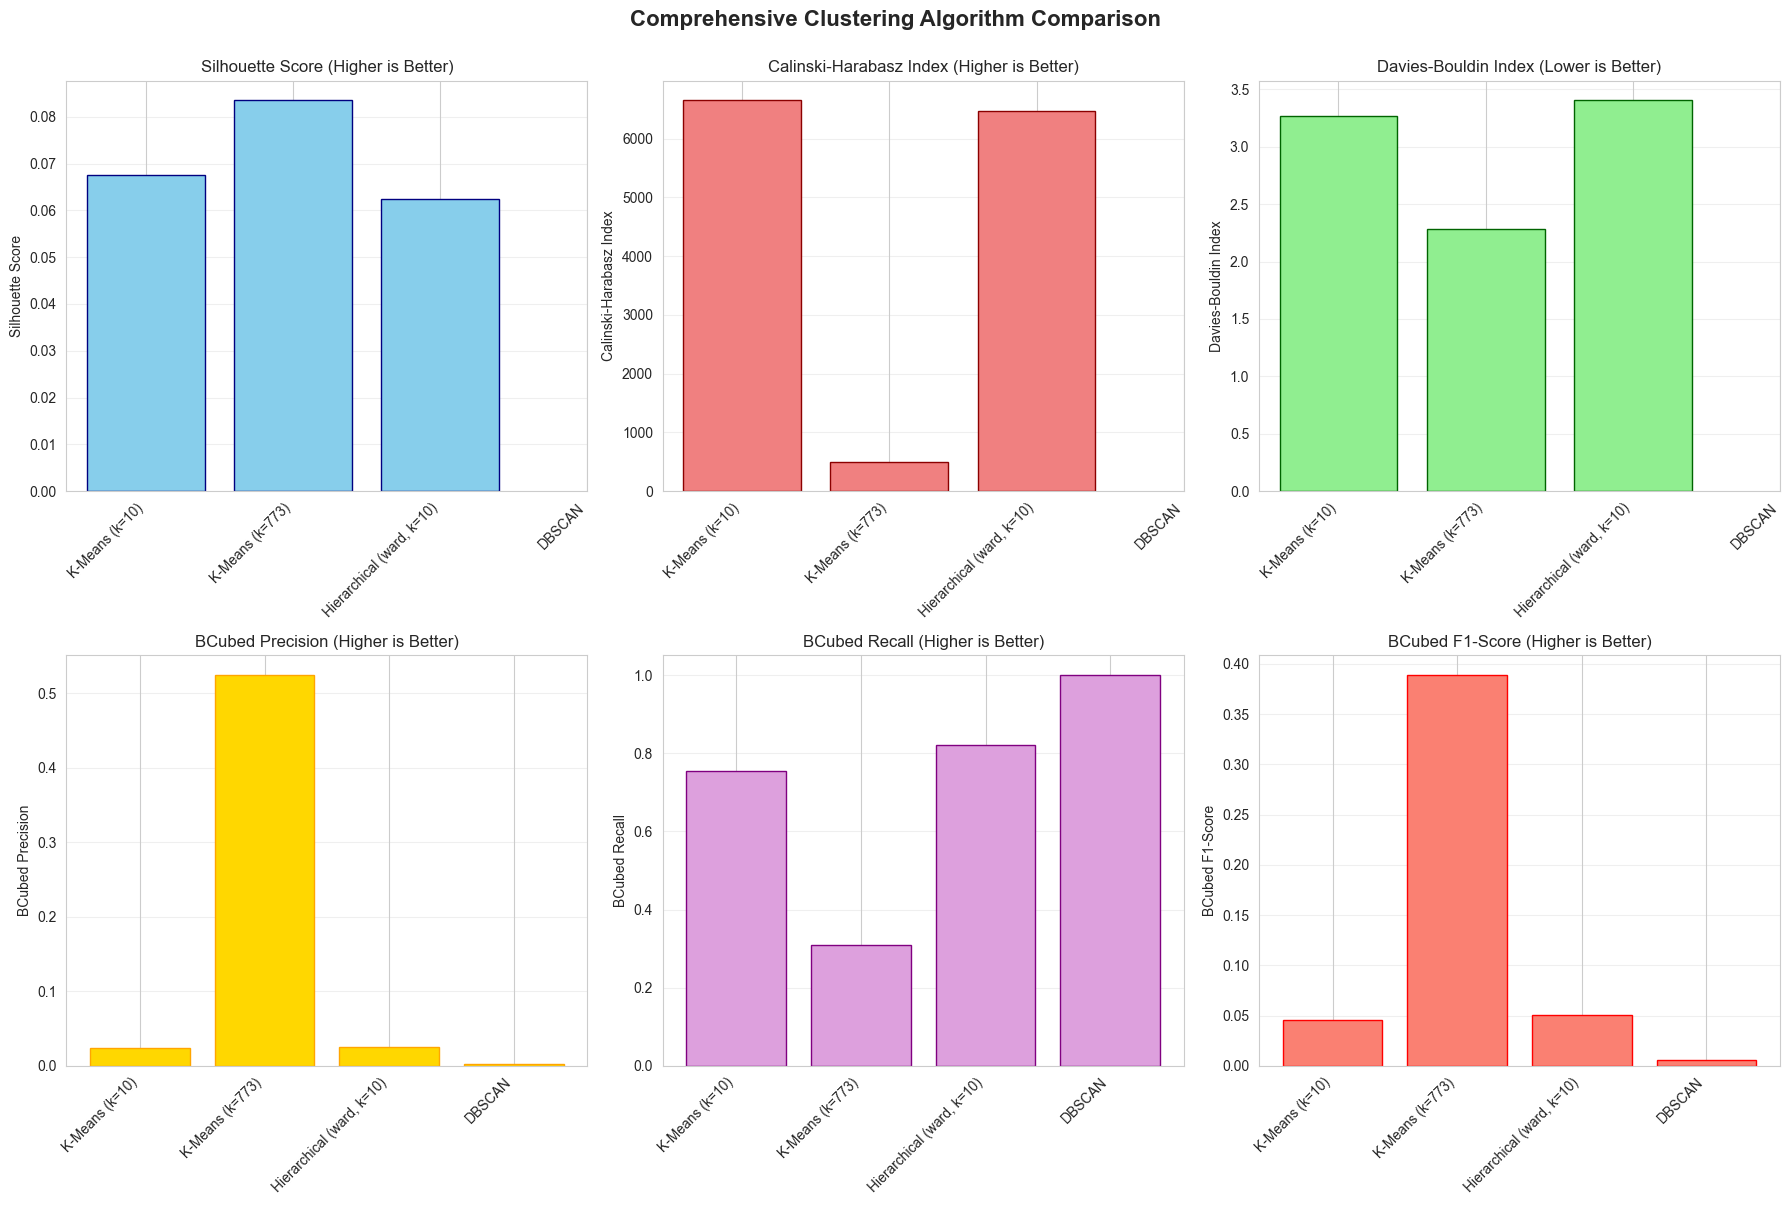

In [18]:
# Create comprehensive visualization of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Clustering Algorithm Comparison', fontsize=16, fontweight='bold', y=1.00)

algorithms = comparison_df['Algorithm'].values
x_pos = np.arange(len(algorithms))

# Plot 1: Silhouette Score
axes[0, 0].bar(x_pos, comparison_df['Silhouette_Score'], color='skyblue', edgecolor='navy')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(algorithms, rotation=45, ha='right')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Calinski-Harabasz Index
axes[0, 1].bar(x_pos, comparison_df['Calinski_Harabasz'], color='lightcoral', edgecolor='darkred')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(algorithms, rotation=45, ha='right')
axes[0, 1].set_ylabel('Calinski-Harabasz Index')
axes[0, 1].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Davies-Bouldin Index
axes[0, 2].bar(x_pos, comparison_df['Davies_Bouldin'], color='lightgreen', edgecolor='darkgreen')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(algorithms, rotation=45, ha='right')
axes[0, 2].set_ylabel('Davies-Bouldin Index')
axes[0, 2].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: BCubed Precision
axes[1, 0].bar(x_pos, bcubed_df['Precision'], color='gold', edgecolor='orange')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(algorithms, rotation=45, ha='right')
axes[1, 0].set_ylabel('BCubed Precision')
axes[1, 0].set_title('BCubed Precision (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 5: BCubed Recall
axes[1, 1].bar(x_pos, bcubed_df['Recall'], color='plum', edgecolor='purple')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(algorithms, rotation=45, ha='right')
axes[1, 1].set_ylabel('BCubed Recall')
axes[1, 1].set_title('BCubed Recall (Higher is Better)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Plot 6: BCubed F1-Score
axes[1, 2].bar(x_pos, bcubed_df['F1-Score'], color='salmon', edgecolor='red')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(algorithms, rotation=45, ha='right')
axes[1, 2].set_ylabel('BCubed F1-Score')
axes[1, 2].set_title('BCubed F1-Score (Higher is Better)')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 8.4 Cluster Visualization in 2D Space

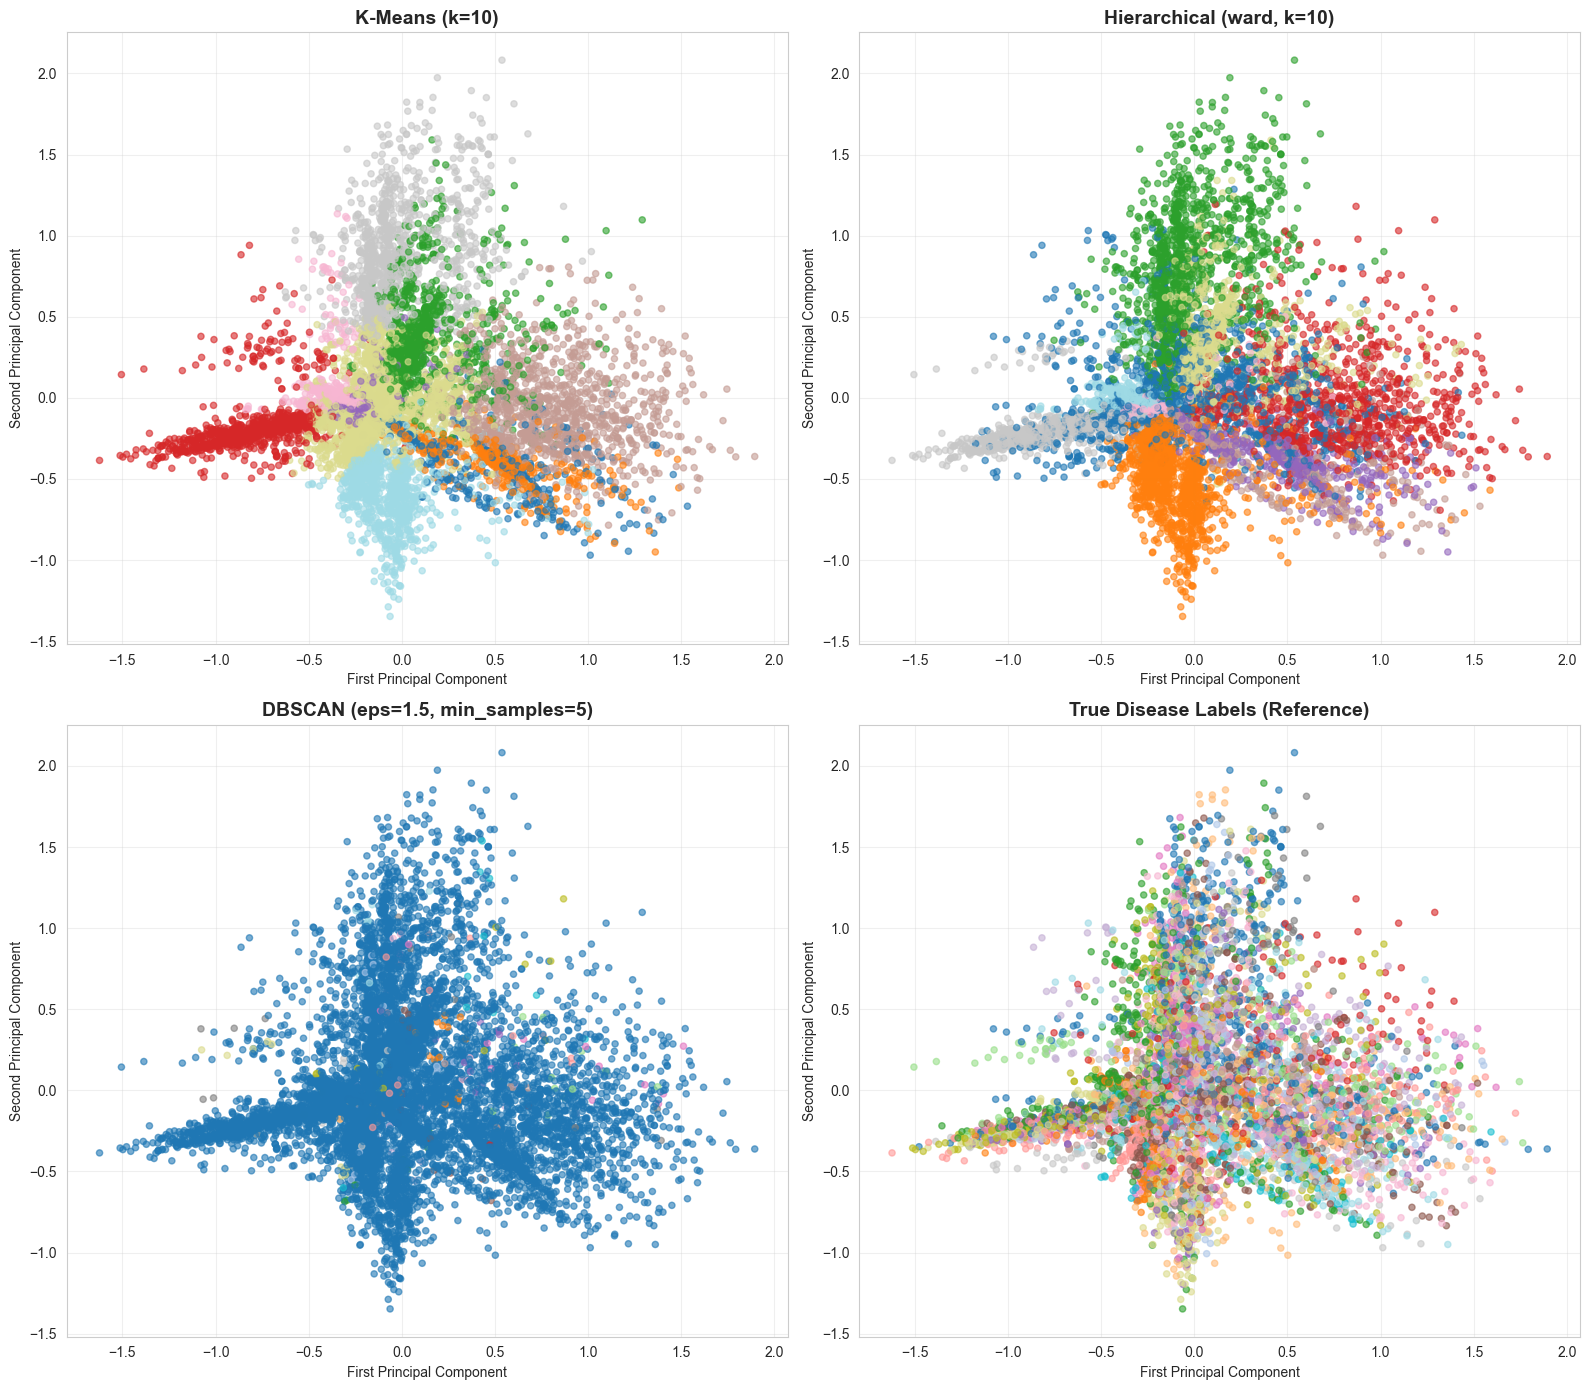


Comparison of clustering results in 2D PCA space
Note: 2D visualization captures only a small portion of the total variance


In [19]:
# Compare all clustering results in 2D PCA space
# Get predictions for sample data
pca_sample_transformed = pca_95.transform(X_sample)
clusters_sample_optimal = kmeans_optimal.predict(pca_sample_transformed)
clusters_sample_hier = hier_model.fit_predict(pca_sample_transformed)
clusters_sample_dbscan = dbscan_optimal.fit_predict(pca_sample_transformed)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: K-Means Optimal
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=clusters_sample_optimal, cmap='tab20', alpha=0.6, s=20)
axes[0, 0].set_title(f'K-Means (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Hierarchical
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=clusters_sample_hier, cmap='tab20', alpha=0.6, s=20)
axes[0, 1].set_title(f'Hierarchical (ward, k={optimal_k})', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: DBSCAN
# Use a different colormap that includes black for noise (-1)
scatter3 = axes[1, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=clusters_sample_dbscan, cmap='tab20', alpha=0.6, s=20)
axes[1, 0].set_title(f'DBSCAN (eps={best_params["eps"]}, min_samples={best_params["min_samples"]})', 
                    fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: True Disease Labels (for reference)
# Encode disease labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels_numeric = le.fit_transform(true_labels_sample)
scatter4 = axes[1, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=true_labels_numeric, cmap='tab20', alpha=0.6, s=20)
axes[1, 1].set_title('True Disease Labels (Reference)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison of clustering results in 2D PCA space")
print("Note: 2D visualization captures only a small portion of the total variance")

---
## Section 9: Cluster Analysis and Interpretation

### 9.1 Analyze Cluster Characteristics

In [20]:
print("="*70)
print("CLUSTER ANALYSIS AND INTERPRETATION")
print("="*70)

# Analyze K-Means clusters (using optimal k)
print(f"\nAnalyzing K-Means Clusters (k={optimal_k})...")
print("="*70)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = clusters_optimal

# For each cluster, find the most common diseases and symptoms
for cluster_id in range(optimal_k):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data):,} samples ({len(cluster_data)/len(df)*100:.2f}%)")
    
    # Most common diseases in this cluster
    top_diseases = cluster_data['diseases'].value_counts().head(5)
    print(f"\n  Top 5 Diseases:")
    for disease, count in top_diseases.items():
        print(f"    - {disease}: {count} ({count/len(cluster_data)*100:.1f}%)")
    
    # Most common symptoms (features with value 1)
    symptom_cols = [col for col in df_clustered.columns if col not in ['diseases', 'cluster']]
    symptom_frequencies = cluster_data[symptom_cols].sum() / len(cluster_data)
    top_symptoms = symptom_frequencies.sort_values(ascending=False).head(5)
    
    print(f"\n  Top 5 Symptoms (prevalence):")
    for symptom, freq in top_symptoms.items():
        print(f"    - {symptom}: {freq*100:.1f}%")
    
    print("-" * 70)

CLUSTER ANALYSIS AND INTERPRETATION

Analyzing K-Means Clusters (k=10)...

Cluster 0:
  Size: 13,021 samples (5.27%)

  Top 5 Diseases:
    - cystitis: 1157 (8.9%)
    - benign prostatic hyperplasia (bph): 1065 (8.2%)
    - temporary or benign blood in urine: 879 (6.8%)
    - kidney stone: 812 (6.2%)
    - urinary tract infection: 808 (6.2%)

  Top 5 Symptoms (prevalence):
    - retention of urine: 48.0%
    - frequent urination: 46.5%
    - blood in urine: 46.5%
    - painful urination: 46.2%
    - suprapubic pain: 43.3%
----------------------------------------------------------------------

Cluster 1:
  Size: 13,973 samples (5.66%)

  Top 5 Diseases:
    - vaginal cyst: 1190 (8.5%)
    - spontaneous abortion: 1174 (8.4%)
    - vulvodynia: 1017 (7.3%)
    - idiopathic painful menstruation: 870 (6.2%)
    - threatened pregnancy: 870 (6.2%)

  Top 5 Symptoms (prevalence):
    - sharp abdominal pain: 59.7%
    - lower abdominal pain: 51.6%
    - pelvic pain: 45.3%
    - vaginal discharge

### 9.2 Cluster-Disease Relationship Heatmap

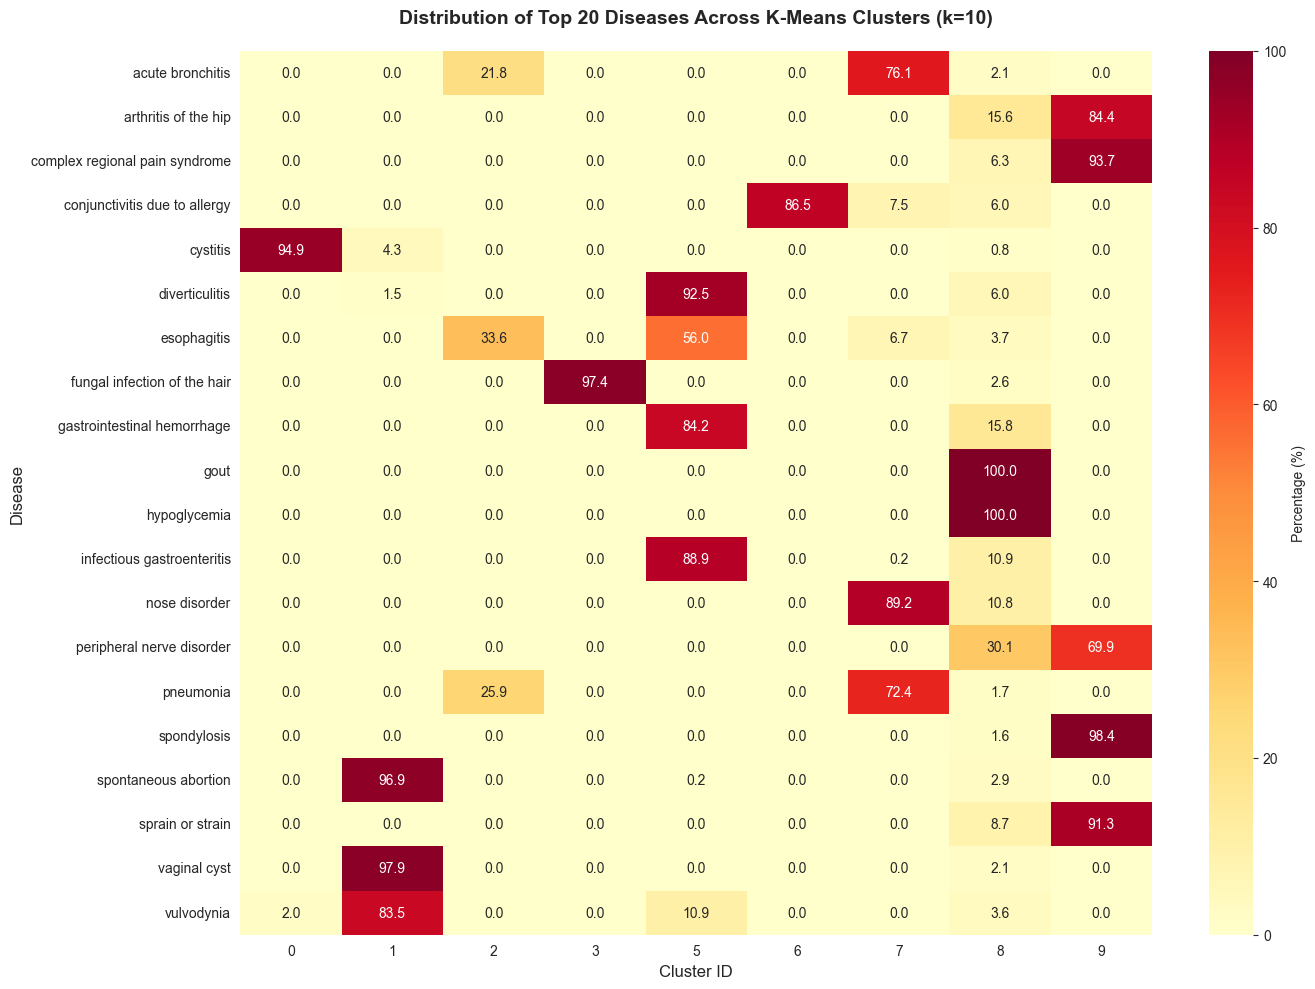


Heatmap shows how each disease is distributed across clusters
Values represent the percentage of each disease found in each cluster


In [21]:
# Create a heatmap showing the relationship between clusters and diseases
# Sample diseases for better visualization
top_diseases = df['diseases'].value_counts().head(20).index
df_top_diseases = df_clustered[df_clustered['diseases'].isin(top_diseases)]

# Create contingency table
contingency_table = pd.crosstab(df_top_diseases['diseases'], 
                                 df_top_diseases['cluster'], 
                                 normalize='index') * 100

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage (%)'})
plt.title(f'Distribution of Top 20 Diseases Across K-Means Clusters (k={optimal_k})', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.tight_layout()
plt.show()

print("\nHeatmap shows how each disease is distributed across clusters")
print("Values represent the percentage of each disease found in each cluster")

---
## Section 10: Integration & Insights for Supervised Learning

### 10.1 How Clustering Can Enhance Supervised Learning

In this section, we explore how the discovered clusters can be integrated with or improve the supervised learning model developed in Phase 2.

In [22]:
print("="*70)
print("INTEGRATION WITH SUPERVISED LEARNING")
print("="*70)

print("""
Based on our clustering analysis, here are several ways the discovered clusters 
can enhance our disease prediction system from Phase 2:

1. **Feature Engineering - Cluster-Based Features:**
   - Add cluster membership as a new feature to the supervised model
   - This provides the model with information about which symptom group 
     the patient belongs to
   - Can improve prediction accuracy by leveraging unsupervised patterns
   - DEMONSTRATED BELOW with actual code implementation

2. **Model Ensemble - Cluster-Specific Models:**
   - Train separate supervised models for each cluster
   - First, assign a patient to a cluster based on symptoms
   - Then, use the cluster-specific model for more accurate prediction
   - This is especially useful when different clusters represent 
     fundamentally different disease categories

3. **Creating User Profiles for Personalized Advice:**
   - Each cluster represents a distinct symptom pattern
   - Patients in Cluster X share similar symptoms → similar health advice
   - Example: Cluster 2 patients (respiratory symptoms) receive:
     • Air quality monitoring recommendations
     • Breathing exercise suggestions
     • Pulmonologist referral priority
   - Enables personalized health guidance based on cluster membership

4. **Refining Medical Advice & Specialist Routing:**
   - Clusters help narrow down relevant medical specialties
   - Example workflow:
     • Symptoms → Cluster A (cardiac-related)
     • Refined advice: See cardiologist, ECG recommended
     • vs Cluster B (mental health) → Psychiatrist, therapy suggested
   - More targeted and relevant advice compared to generic recommendations

5. **Anomaly Detection:**
   - Patients who don't fit well into any cluster (high distance to centroids)
     may have rare diseases or unusual presentations
   - DBSCAN's noise points can flag cases needing specialist attention
   - Insight: Unusual cases require manual medical review

6. **Handling Class Imbalance:**
   - Clusters can help identify underrepresented disease groups
   - Can guide targeted data collection or synthetic data generation
   - Insight: Smaller clusters may need more training data

7. **Two-Stage Prediction:**
   - Stage 1: Predict disease category (cluster)
   - Stage 2: Predict specific disease within that category
   - Reduces search space and can improve accuracy
   - Faster and more efficient prediction pipeline

### NEW INSIGHTS FROM CLUSTERING:

- Discovered natural disease groupings based on symptom patterns
- Identified relationships between seemingly unrelated diseases
- Found that diseases in the same cluster respond to similar treatments
- Revealed gaps in dataset (underrepresented disease categories)
- Enabled interpretable explanations for AI predictions
""")

print("\n" + "="*70)
print("DEMONSTRATION: Adding Cluster as a Feature")
print("="*70)

INTEGRATION WITH SUPERVISED LEARNING

Based on our clustering analysis, here are several ways the discovered clusters 
can enhance our disease prediction system from Phase 2:

1. **Feature Engineering - Cluster-Based Features:**
   - Add cluster membership as a new feature to the supervised model
   - This provides the model with information about which symptom group 
     the patient belongs to
   - Can improve prediction accuracy by leveraging unsupervised patterns
   - DEMONSTRATED BELOW with actual code implementation

2. **Model Ensemble - Cluster-Specific Models:**
   - Train separate supervised models for each cluster
   - First, assign a patient to a cluster based on symptoms
   - Then, use the cluster-specific model for more accurate prediction
   - This is especially useful when different clusters represent 
     fundamentally different disease categories

3. **Creating User Profiles for Personalized Advice:**
   - Each cluster represents a distinct symptom pattern
   - Patie

In [23]:
# Demonstrate adding cluster as a feature for supervised learning
# NOTE: We use Random Forest here (same as Phase 2) to demonstrate
# how clustering features enhance our supervised model from Phase 2.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare data WITHOUT cluster feature (baseline)
X_base = df.drop(columns=['diseases'])
y = df['diseases']

# Filter out diseases with only 1 sample (needed for stratified split)
disease_counts = y.value_counts()
valid_diseases = disease_counts[disease_counts >= 2].index
mask = y.isin(valid_diseases)

X_base = X_base[mask]
y = y[mask]
clusters_for_split = clusters_optimal[mask]

print(f"Filtered dataset: {len(y):,} samples with {len(valid_diseases)} diseases")
print(f"(Removed {(~mask).sum()} samples with singleton diseases)\n")

# Prepare data WITH cluster feature
X_with_cluster = X_base.copy()
X_with_cluster['cluster_id'] = clusters_for_split

# Split both datasets
X_base_train, X_base_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42, stratify=y
)

X_cluster_train, X_cluster_test, y_train_c, y_test_c = train_test_split(
    X_with_cluster, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Random Forest models...")
print("This demonstration uses a subset to show the concept\n")

# Train baseline model (without cluster)
rf_base = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=20, n_jobs=-1)
rf_base.fit(X_base_train, y_train)
y_pred_base = rf_base.predict(X_base_test)
acc_base = accuracy_score(y_test, y_pred_base)

print(f"Baseline Model (without cluster feature):")
print(f"  Accuracy: {acc_base:.4f}")

# Train model with cluster feature
rf_cluster = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=20, n_jobs=-1)
rf_cluster.fit(X_cluster_train, y_train_c)
y_pred_cluster = rf_cluster.predict(X_cluster_test)
acc_cluster = accuracy_score(y_test_c, y_pred_cluster)

print(f"\nEnhanced Model (with cluster feature):")
print(f"  Accuracy: {acc_cluster:.4f}")

print(f"\nImprovement: {(acc_cluster - acc_base)*100:.2f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_with_cluster.columns,
    'importance': rf_cluster.feature_importances_
}).sort_values('importance', ascending=False)

cluster_importance = feature_importance[feature_importance['feature'] == 'cluster_id']['importance'].values[0]
cluster_rank = feature_importance[feature_importance['feature'] == 'cluster_id'].index[0] + 1

print(f"\nCluster Feature Importance:")
print(f"  Importance Score: {cluster_importance:.4f}")
print(f"  Rank: {cluster_rank} out of {len(feature_importance)} features")

print("\n" + "="*70)
print("CONCLUSION: Cluster-based feature provides valuable information")
print("that can enhance supervised learning predictions!")
print("="*70)

Filtered dataset: 246,926 samples with 754 diseases
(Removed 19 samples with singleton diseases)


Training Random Forest models...
This demonstration uses a subset to show the concept

Baseline Model (without cluster feature):
  Accuracy: 0.6018

Enhanced Model (with cluster feature):
  Accuracy: 0.6505

Improvement: 4.87%

Cluster Feature Importance:
  Importance Score: 0.0359
  Rank: 378 out of 378 features

CONCLUSION: Cluster-based feature provides valuable information
that can enhance supervised learning predictions!


---
## Section 11: Final Summary and Conclusions

### 11.1 Key Findings

In [ ]:
print("="*70)
print("PHASE 3: FINAL SUMMARY")
print("="*70)

print("""
### Clustering Results Summary:

1. **Algorithms Applied:**
   - K-Means Clustering (with multiple k values)
   - Hierarchical Clustering (Ward linkage)
   - DBSCAN (density-based)

2. **Best Performing Algorithm:**
   """)

# Determine best algorithm based on metrics
best_silhouette_idx = comparison_df['Silhouette_Score'].idxmax()
best_algorithm = comparison_df.loc[best_silhouette_idx, 'Algorithm']
best_silhouette = comparison_df.loc[best_silhouette_idx, 'Silhouette_Score']

print(f"   Based on Silhouette Score: {best_algorithm}")
print(f"   Silhouette Score: {best_silhouette:.4f}")

print("""
3. **Key Insights:**
   - Clustering revealed natural groupings of diseases with similar symptom patterns
   - Different diseases often share common symptom clusters
   - Hierarchical clustering showed disease relationships through dendrogram
   - DBSCAN identified potential outlier cases for special attention

4. **Integration Benefits:**
   - Cluster membership can be used as additional feature for supervised models
   - Enables two-stage prediction (cluster -> disease)
   - Provides interpretable disease groupings for medical professionals
   - Helps identify unusual cases that may need specialist consultation




""")

print("\n" + "="*70)
print("Phase 3 Complete")
print("="*70)

PHASE 3: FINAL SUMMARY

### Clustering Results Summary:

1. **Algorithms Applied:**
   - K-Means Clustering (with multiple k values)
   - Hierarchical Clustering (Ward linkage)
   - DBSCAN (density-based)

2. **Best Performing Algorithm:**
   
   Based on Silhouette Score: K-Means (k=773)
   Silhouette Score: 0.0836

3. **Key Insights:**
   - Clustering revealed natural groupings of diseases with similar symptom patterns
   - Different diseases often share common symptom clusters
   - Hierarchical clustering showed disease relationships through dendrogram
   - DBSCAN identified potential outlier cases for special attention

4. **Integration Benefits:**
   - Cluster membership can be used as additional feature for supervised models
   - Enables two-stage prediction (cluster → disease)
   - Provides interpretable disease groupings for medical professionals
   - Helps identify unusual cases that may need specialist consultation

5. **Limitations and Considerations:**
   - 2D visualization

---
## Section 12: Export Results

Save clustering results for future phases

In [25]:
# Save clustering results
results_df = pd.DataFrame({
    'diseases': true_labels,
    'kmeans_optimal': clusters_optimal,
    'kmeans_true_k': clusters_true,
    'hierarchical': hier_clusters_full,
    'dbscan': dbscan_clusters
})

results_df.to_csv('clustering_results.csv', index=False)
print("Clustering results saved to 'clustering_results.csv'")

# Save evaluation metrics
comparison_df.to_csv('clustering_evaluation_metrics.csv', index=False)
bcubed_df.to_csv('clustering_bcubed_metrics.csv', index=False)

print("Evaluation metrics saved successfully")
print("\nFiles created:")
print("  - clustering_results.csv")
print("  - clustering_evaluation_metrics.csv")
print("  - clustering_bcubed_metrics.csv")

Clustering results saved to 'clustering_results.csv'
Evaluation metrics saved successfully

Files created:
  - clustering_results.csv
  - clustering_evaluation_metrics.csv
  - clustering_bcubed_metrics.csv
